In [56]:
import pandas as pd
import numpy as np
import yfinance as yf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from finm37000.settings import config
import databento as db
import plotly.express as px
from finm37000 import constant_maturity_splice
from zoneinfo import ZoneInfo
import datetime
from finm37000 import get_roll_spec
from pandas.tseries.offsets import BDay
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Data Loading

## 1.1 Loading and processing CFTC data

In [6]:
# Reading data
gc_oi = pd.read_csv("../../data/GC_COT_data.csv")

# Preprocessing with datetime
gc_oi['Date Time'] = pd.to_datetime(gc_oi['Date Time'])
gc_oi.rename(columns={'Date Time':'Date'},inplace=True)
gc_oi.set_index("Date",inplace=True)

# CFTC data is supposed to be Tuesdays data released on Friday.
# Barchart.com data timestamp is on Monday thus shift it to the same week Friday
gc_oi.index = gc_oi.index + pd.offsets.Week(weekday=4)


## 1.2 Loading and processing ETF inflow data

In [7]:
# ETF inflow data from wrds, two biggest gold ETF; GLD and IAU
gold_etf_data = pd.read_csv("../../data/gold_etf_inflow.csv",index_col='as_of_date').drop(columns=['etfg_date'])
gold_etf_data.index = pd.to_datetime(gold_etf_data.index)
gld_etf = gold_etf_data[gold_etf_data['composite_ticker'] == 'GLD']
iau_etf = gold_etf_data[gold_etf_data['composite_ticker'] == 'IAU']
# I summed up two etf net inflows
# The net inflows we can only know this data after settlement
total_etf = (gld_etf['fundflow'] + iau_etf['fundflow']).shift(1).dropna()


## 1.3 Loading and processing yahoo finance data

In [26]:
start = "2013-08-23" # bc of CFTC data
end = "2025-09-30"

# GLD: Gold ETF
# TNX : T10
# DX-Y: Dollar index
# GVZ : Gold volatility index
# GDX : Gold Miners ETF

yf_data = yf.download(['GLD','^TNX','DX-Y.NYB','^GVZ','GDX','SLV','SPY'],start,end,auto_adjust=True)['Close'].dropna()

[*********************100%***********************]  7 of 7 completed


## 1.4 Loading databento data - creating a client

Below code is to pull out GC constant maturity contract of 90days.

For greater constant maturity, there are more data with null values thus we restrict it to 90 days.

We are pulling out this data to calculate (hypothetical) carry cost. 

Carry cost should use spot price and its futures price but we use GLD ETF as a proxy for gold.

Thus, the calculation will not exactly be the carry cost but the relative movement should be helpful for our analysis

Also, we do recognize that ohlcv-1d is UTC based but if we take the close price then its around 6-7 CT close to market close time 3PM CT.

So we use such data without any other processing

In [ ]:
databento_api_key = config("DATABENTO_API_KEY")
client = db.Historical(databento_api_key)

tz_chicago = ZoneInfo("America/Chicago")
product='GC'
start = yf_data.index[0].date()
end = yf_data.index[-1].date()

In [17]:
# The constant maturity should be longer than active month frequency
num_contracts = 4
constant_maturity = tuple(f"{product}.cm.{90 * (i + 1)}" for i in range(num_contracts))
constant_maturity

('GC.cm.90', 'GC.cm.180', 'GC.cm.270', 'GC.cm.360')

In [ ]:
active_month = ["G", "J", "M", "Q", "V", "Z"] # even number months
active_month_df = pd.DataFrame()

# For every year checking active contracts
iteration = int(np.ceil((end-start)/pd.Timedelta(days=365)))
for it in range(iteration):
    instrument_defs = client.timeseries.get_range(
        dataset="GLBX.MDP3",
        schema="definition",
        symbols=f"{product}.FUT",
        stype_in="parent",
        # Checking every year and ensuring it is a businessday
        start =(yf_data.index[0]+pd.Timedelta(days=365*it)+ BDay(0)).date(),
        # end = yf_data.index[-1].date()
    ).to_df()
    # Filtering out active months and futures(not spread)
    active_months = instrument_defs[
    instrument_defs["raw_symbol"].str.slice(2, 3).isin(active_month) 
    & (instrument_defs["instrument_class"] == "F")
]
    active_month_df = pd.concat([active_month_df,active_months],axis=0)

In [20]:
cm_specs = {
    symbol: get_roll_spec(
        symbol,
        active_month_df.reset_index(),
        start=yf_data.index[0].date(),
        end=yf_data.index[-1].date(),
    )
    for symbol in constant_maturity
}

# instrument id
cm_instruments = {
    int(spec[key])
    for spec_list in cm_specs.values()
    for spec in spec_list
    for key in (
        "p",
        "n",
    )
}

ohlcv = client.timeseries.get_range(
    dataset="GLBX.MDP3",
    schema="ohlcv-1d",
    symbols=cm_instruments,
    stype_in="instrument_id",
    start=yf_data.index[0],
    end=yf_data.index[-1],
).to_df()

expirations = active_month_df[["instrument_id", "expiration"]].drop_duplicates()
ohlcv_with_exp = (
    ohlcv.reset_index()
    .merge(expirations, on="instrument_id", how="left")
    .set_index("ts_event")
)

C:\Users\moose\AppData\Local\Temp\ipykernel_30216\1587770087.py:22: BentoWarning: The streaming request contained one or more days which have reduced quality: 2017-11-13 (degraded), 2018-10-21 (degraded), 2019-01-15 (degraded)... See: https://databento.com/docs/api-reference-historical/metadata/metadata-get-dataset-condition
  ohlcv = client.timeseries.get_range(


In [21]:
cm_pieces = {
    symbol: constant_maturity_splice(
        symbol,
        roll_spec,
        ohlcv_with_exp.reset_index(),
        date_col="ts_event",
        price_col="close",
    )
    for symbol, roll_spec in cm_specs.items()
}

cm_long = [
    pd.wide_to_long(
        df, stubnames=["GC.cm"], i="ts_event", j="days_to_maturity", sep="."
    )
    for df in cm_pieces.values()
]
cm_close = pd.concat(cm_long)

In [24]:
cm_df = cm_close.xs(90,level='days_to_maturity')['GC.cm'].tz_localize(None)

In [25]:
yf_data = pd.merge(yf_data,cm_df,left_index=True,right_index=True)
yf_data

,DX-Y.NYB,GDX,GLD,SLV,SPY,^GVZ,^TNX,GC.cm
2013-08-23,81.339996,26.866076,134.899994,23.150000,134.719254,22.629999,2.818,1396.486838
2013-08-26,81.370003,27.106747,135.449997,23.459999,134.217957,23.670000,2.805,1402.871595
2013-08-27,81.169998,25.939043,136.750000,23.590000,132.059143,23.900000,2.721,1417.989450
2013-08-28,81.419998,25.225943,136.710007,23.430000,132.528137,25.889999,2.782,1417.638567
2013-08-29,81.949997,25.439875,135.869995,23.000000,132.738373,24.360001,2.751,1403.735180
...,...,...,...,...,...,...,...,...
2025-09-22,97.330002,74.330002,345.049988,40.040001,666.840027,18.430000,4.143,3777.889420
2025-09-23,97.260002,74.230003,346.459991,39.959999,663.210022,19.059999,4.120,3792.039010
2025-09-24,97.870003,72.320000,343.320007,39.820000,661.099976,18.299999,4.147,3771.116894
2025-09-25,98.550003,73.129997,344.750000,41.029999,658.049988,19.070000,4.172,3771.946382


## 1.5 Merging dataframes

### Daily frequency - Use merge asof for Managed OI position


In [27]:
# For below two, it is daily matched data 
daily_merged = pd.merge(yf_data,cm_df,left_index=True,right_index=True)
daily_merged = pd.merge(daily_merged,total_etf,left_index=True,right_index=True)

# Merge asof join 
daily_merged = pd.merge_asof(daily_merged,gc_oi,left_index=True,right_index=True)
daily_merged

,DX-Y.NYB,GDX,GLD,SLV,SPY,^GVZ,^TNX,GC.cm,fundflow,Symbol,Small Spec,Producers,Swap Dealers,Managed Money,Other Report
2013-08-23,81.339996,26.866076,134.899994,23.150000,134.719254,22.629999,2.818,1396.486838,0.000000e+00,GCZ13,7269,-12340,-55325,48416,11980
2013-08-26,81.370003,27.106747,135.449997,23.459999,134.217957,23.670000,2.805,1402.871595,2.922700e+08,GCZ13,7269,-12340,-55325,48416,11980
2013-08-27,81.169998,25.939043,136.750000,23.590000,132.059143,23.900000,2.721,1417.989450,0.000000e+00,GCZ13,7269,-12340,-55325,48416,11980
2013-08-28,81.419998,25.225943,136.710007,23.430000,132.528137,25.889999,2.782,1417.638567,3.991200e+07,GCZ13,7269,-12340,-55325,48416,11980
2013-08-29,81.949997,25.439875,135.869995,23.000000,132.738373,24.360001,2.751,1403.735180,0.000000e+00,GCZ13,7269,-12340,-55325,48416,11980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,97.330002,74.330002,345.049988,40.040001,666.840027,18.430000,4.143,3777.889420,2.330448e+09,GCZ25,35961,-65384,-236987,158971,107439
2025-09-23,97.260002,74.230003,346.459991,39.959999,663.210022,19.059999,4.120,3792.039010,7.081179e+08,GCZ25,35961,-65384,-236987,158971,107439
2025-09-24,97.870003,72.320000,343.320007,39.820000,661.099976,18.299999,4.147,3771.116894,0.000000e+00,GCZ25,35961,-65384,-236987,158971,107439
2025-09-25,98.550003,73.129997,344.750000,41.029999,658.049988,19.070000,4.172,3771.946382,-1.247889e+08,GCZ25,35961,-65384,-236987,158971,107439


### Weekly frequency - Take the last for other variables and use sum for ETF inflow

In [85]:
# resampled_df_copy is a weekly merged data

In [28]:
# For fundflow we can't just take the last rather we accumulate those daily inflows
agg_dict = {col: 'last' for col in daily_merged.columns}
agg_dict['fundflow'] = 'sum'

# Because OI data is weekly and daily is noisy we resample it by each week Friday
resampled_df = daily_merged.resample("W-FRI").agg(agg_dict)
resampled_df_copy = resampled_df.copy()

# The raw level is not so useful in contemporaneous or prediction 
# fundflow and Managed money is mean reverting in the long run also relative positioning is important than levels.
window = 26   # weekly (rolling 26 weeks/ around 6months)
cols = ['fundflow', 'Managed Money','^GVZ']

for c in cols:
    mu = resampled_df_copy[c].rolling(window).mean()
    sigma = resampled_df_copy[c].rolling(window).std()
    resampled_df_copy[c + '_z'] = (resampled_df_copy[c] - mu) / sigma

Constructing carry cost proxy columns

In [45]:
ER = 0.004   # 0.40%
# GLD ETF has 40bp annual expense - if we just use the price then we falsely can see upward drfting carry proxy

resampled_df_copy["t_years"] = (resampled_df_copy.index - resampled_df_copy.index[0]).days / 365
resampled_df_copy["GLD_adj"] = resampled_df_copy["GLD"] * np.exp(ER * resampled_df_copy["t_years"])

In [46]:
resampled_df_copy['cc_proxy'] = np.log(resampled_df_copy['GC.cm']/resampled_df_copy['GLD_adj'])/(90/365)
resampled_df_copy

,DX-Y.NYB,GDX,GLD,SLV,SPY,^GVZ,^TNX,GC.cm,fundflow,Symbol,...,Producers,Swap Dealers,Managed Money,Other Report,fundflow_z,Managed Money_z,^GVZ_z,cc_proxy,t_years,GLD_adj
2013-08-23,81.339996,26.866076,134.899994,23.150000,134.719254,22.629999,2.818,1396.486838,0.000000e+00,GCZ13,...,-12340,-55325,48416,11980,NaN,NaN,NaN,9.478568,0.000000,134.899994
2013-08-30,82.089996,25.074409,134.619995,22.600000,132.317902,24.440001,2.749,1395.998306,3.321820e+08,GCZ13,...,-20530,-67108,70389,7900,NaN,NaN,NaN,9.485265,0.019178,134.630323
2013-09-06,82.150002,24.967443,134.149994,22.969999,134.250259,23.590000,2.938,1388.654270,-8.082000e+07,GCZ13,...,-24639,-67822,75400,2791,NaN,NaN,NaN,9.477746,0.038356,134.170577
2013-09-13,81.449997,22.845966,127.820000,21.420000,136.910400,24.879999,2.898,1327.226041,-1.201380e+08,GCZ13,...,-16868,-63356,64780,3944,NaN,NaN,NaN,9.489972,0.057534,127.849419
2013-09-20,80.440002,22.961849,127.959999,21.000000,138.707108,22.270000,2.732,1325.733698,-2.062160e+08,GCZ13,...,-10904,-54433,54780,4016,NaN,NaN,NaN,9.480659,0.076712,127.999270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-29,97.769997,63.169998,318.070007,36.189999,643.266602,17.389999,4.227,3500.853174,1.504089e+09,GCZ25,...,-42328,-208637,141917,72394,1.286808,0.301258,-0.487609,9.532145,12.024658,333.742633
2025-09-05,97.769997,66.339996,331.049988,37.209999,645.450500,18.299999,4.086,3627.556655,1.748981e+09,GCZ25,...,-55302,-218596,161502,88028,1.476890,1.203127,-0.241074,9.513806,12.043836,347.388839
2025-09-12,97.550003,69.750000,335.420013,38.340000,655.592407,16.379999,4.061,3671.720751,3.349788e+08,GCZ25,...,-62554,-210821,163519,98221,-0.160950,1.315328,-0.814023,9.509386,12.063014,352.001548
2025-09-19,97.639999,72.360001,339.179993,39.040001,663.700012,16.760000,4.139,3713.576451,7.953731e+08,GCZ25,...,-65384,-236987,158971,107439,0.383217,1.251658,-0.713275,9.509836,12.082192,355.974709


# 2. Few plots to see the relationship between gold and variable of our interest

Plot 1 - GLD Price vs Managed Money Net Long OI

- Gold Price and Managed Money Net Long OI is positively correlated throughout the sample
- But the correlation drops for the two recent big jumps; COVID and 2025
- My guess for positive correlation is that those Managed Money uses momentum strategy, so they long more then price goes up.
- Not only extreme event gives information but as it is mean reverting, direction of continuing z-score can be helpful

In [31]:

# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'], name="GLD Price"),
    secondary_y=False
)

# 3) Second y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['Managed Money'], name="Managed Money Net Long OI"),
    secondary_y=True
)

# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="Managed Money Net Long OI", secondary_y=True)

fig.show()

In [32]:

# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) Second y axis
fig.add_trace(
    go.Scatter(x=resampled_df_copy.index, y=resampled_df_copy['GLD'].rolling(60).corr(resampled_df_copy['Managed Money']), name="Managed Money vs GLD corr"),
    secondary_y=True
)
# 4) y axis name
fig.update_yaxes(title_text="GLD Managed Money vs GLD corr", secondary_y=True)

fig.show()

Plot 2 - GLD Price vs DXY 

- Most of the time gold price and dollar index has inverse relationship.
- When dollar strengthens gold is paid with dollars so less price 
- Also, interest rate hikes follows with dollar surge , making gold less attractive under high interest rate regime.

In [33]:

# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'], name="GLD Price"),
    secondary_y=False
)

# 3) Second y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['DX-Y.NYB'], name="Dollar Index"),
    secondary_y=True
)

# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="Dollar Index", secondary_y=True)

fig.show()

In [34]:

# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'].rolling(60).corr(daily_merged['DX-Y.NYB']), name="GLD vs DXY Roling corr 60D"),
    secondary_y=False
)


# 4) y axis name
fig.update_yaxes(title_text="GLD vs DXY Roling corr", secondary_y=False)

fig.show()

Plot 3 - GLD Price vs 10 Year CM 

- Gold doesn't have interest rate thus, as the 10 year rate goes up gold price tends to go down.

- But recent pattern shows the relationship might have been changed.

- Like dollar index, the reaction is pretty mixed.

In [36]:

# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'], name="GLD Price"),
    secondary_y=False
)

# 3) Second y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['^TNX'], name="10 Year rate"),
    secondary_y=True
)

# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="10 Year rate", secondary_y=True)

fig.show()

In [37]:

# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'].rolling(120).corr(daily_merged['^TNX']), name="Gold vs 10yr rate 120D"),
    secondary_y=False
)

# 4) y axis name
fig.update_yaxes(title_text="Gold vs 10yr rate", secondary_y=False)


fig.show()

Plot 4 - GLD Price with ETF inflow

Similar to Manged Money OI, ETF inflow closely flow the GLD price

In [39]:

# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=resampled_df_copy.index, y=resampled_df_copy['GLD'], name="GLD Price"),
    secondary_y=False
)

# 3) Second y axis
fig.add_trace(
    go.Scatter(x=resampled_df_copy.index, y=resampled_df_copy['fundflow'].rolling(26).sum(), name="ETF Net inflow 26 Weekly Rolling sum"),
    secondary_y=True
)

# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="ETF Net inflow 26 Weekly Rolling sum", secondary_y=True)

fig.show()

Plot 5 - Gold Price and rolling correlation with ETF flows

ETF inflow is most of the time positively correlated to gold price.

In [94]:
# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=resampled_df_copy.index, y=resampled_df_copy['GLD'], name="GLD Price"),
    secondary_y=False
)

# 3) Second y axis
fig.add_trace(
    go.Scatter(x=resampled_df_copy.index, y=resampled_df_copy['fundflow'].rolling(26).sum().rolling(26).corr(resampled_df_copy['GLD']), name="ETF Net inflow Rolling sum rolling 26W Correlation"),
    secondary_y=True
)

# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="ETF Net inflow Rolling sum rolling 26W Correlation", secondary_y=True)

fig.show()

Plot 7- Gold vs Silver

- Gold and Silver behaves quite similarly as can be seen in price chart and correlation chart below.
- Most of the time under bear market, gold outperforms and during bull silver outperforms

In [95]:
# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'], name="GLD Price"),
    secondary_y=False
)

# 3) Second y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['SLV'].rolling(60).corr(daily_merged['GLD']), name="Silver Gold 60D Rolling Correlation"),
    secondary_y=True
)

# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="Silver Price correlation", secondary_y=True)

fig.show()

In [96]:
# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=yf_data.index, y=yf_data['GLD'], name="GLD Price"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=yf_data.index, y=yf_data['SLV'], name="SLV Price"),
    secondary_y=True
)



# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="SLV Price", secondary_y=True)

fig.show()

Plot 9 - Gold Volaility index

Interestingly, the fact that gold volatility index is high doesnt necessarily mean the price went down
Rather, high gold volatility signals upcoming bull run(?)

In [40]:
# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'], name="GLD Price"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['^GVZ'], name="Gold Volatility Index"),
    secondary_y=True
)



# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="Gold Volatility index", secondary_y=True)

fig.show()

In [41]:
# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'], name="GLD Price"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['^GVZ'].rolling(60).corr(daily_merged['GLD']), name="GLD vs GVZ Rolling 60D Correlation"),
    secondary_y=True
)



# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="Gold Volatility index", secondary_y=True)

fig.show()

In [47]:
# 1) subplot 
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 2) First y axis
fig.add_trace(
    go.Scatter(x=daily_merged.index, y=daily_merged['GLD'], name="GLD Price"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=resampled_df_copy.index, y=resampled_df_copy['cc_proxy'], name="cc_proxy"),
    secondary_y=True
)



# 4) y axis name
fig.update_yaxes(title_text="GLD Price", secondary_y=False)
fig.update_yaxes(title_text="cc_proxy", secondary_y=True)

fig.show()

In [43]:
resampled_df_copy

,DX-Y.NYB,GDX,GLD,SLV,SPY,^GVZ,^TNX,GC.cm,fundflow,Symbol,Small Spec,Producers,Swap Dealers,Managed Money,Other Report,fundflow_z,Managed Money_z,^GVZ_z,cc_proxy
2013-08-23,81.339996,26.866076,134.899994,23.150000,134.719254,22.629999,2.818,1396.486838,0.000000e+00,GCZ13,7269,-12340,-55325,48416,11980,NaN,NaN,NaN,9.478568
2013-08-30,82.089996,25.074409,134.619995,22.600000,132.317902,24.440001,2.749,1395.998306,3.321820e+08,GCZ13,9349,-20530,-67108,70389,7900,NaN,NaN,NaN,9.485576
2013-09-06,82.150002,24.967443,134.149994,22.969999,134.250259,23.590000,2.938,1388.654270,-8.082000e+07,GCZ13,14270,-24639,-67822,75400,2791,NaN,NaN,NaN,9.478368
2013-09-13,81.449997,22.845966,127.820000,21.420000,136.910400,24.879999,2.898,1327.226041,-1.201380e+08,GCZ13,11500,-16868,-63356,64780,3944,NaN,NaN,NaN,9.490906
2013-09-20,80.440002,22.961849,127.959999,21.000000,138.707108,22.270000,2.732,1325.733698,-2.062160e+08,GCZ13,6541,-10904,-54433,54780,4016,NaN,NaN,NaN,9.481904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-29,97.769997,63.169998,318.070007,36.189999,643.266602,17.389999,4.227,3500.853174,1.504089e+09,GCZ25,36654,-42328,-208637,141917,72394,1.286808,0.301258,-0.487609,9.727211
2025-09-05,97.769997,66.339996,331.049988,37.209999,645.450500,18.299999,4.086,3627.556655,1.748981e+09,GCZ25,24368,-55302,-218596,161502,88028,1.476890,1.203127,-0.241074,9.709183
2025-09-12,97.550003,69.750000,335.420013,38.340000,655.592407,16.379999,4.061,3671.720751,3.349788e+08,GCZ25,11635,-62554,-210821,163519,98221,-0.160950,1.315328,-0.814023,9.705075
2025-09-19,97.639999,72.360001,339.179993,39.040001,663.700012,16.760000,4.139,3713.576451,7.953731e+08,GCZ25,35961,-65384,-236987,158971,107439,0.383217,1.251658,-0.713275,9.705836


Few Findings
1. Managed Money / ETF inflow

Managed Money net long OI and ETF inflow has very high correlation with the spot gold price in general.
- This may be due to managed money are shifting their position according to the gold price movement
- For ETF inflow, market makers have to buy gold in order to create ETF(he more the ETF is sold they have to buy more gold).


Quick summary

1. Dollar index - Most of the time inverse relationship to gold

2. T10 - Same with dollar index

3. Gold Vol Index - Gold volatility index not only spikes at sharp drops

5. Silver - Highly correlated to gold

6. ETF inflows - Highly correlated to gold

7. Managed Money OI - Highly correlated to gold

When to use pct_change, z-score and extreme binary
- pct_change : if there is a time series trend 
- z-score: if you believe in mean reverting and its relative positioning is important
- binary : Only extreme events give you information

# OLS regression

Before we regress gold on other variables lets check stationarity to avoid spurious regression

In [48]:
rolling_window = 26

resampled_df_copy[['fundflow_rolling','Managed Money_rolling']] = resampled_df_copy[['fundflow','Managed Money']].rolling(rolling_window).sum()

resampled_df_copy['fundflow_rolling_z'] = (
    resampled_df_copy['fundflow_rolling'] - 
    resampled_df_copy['fundflow_rolling'].rolling(rolling_window).mean()
) / resampled_df_copy['fundflow_rolling'].rolling(rolling_window).std()

resampled_df_copy['ManagedMoney_rolling_z'] = (
    resampled_df_copy['Managed Money_rolling'] - 
    resampled_df_copy['Managed Money_rolling'].rolling(rolling_window).mean()
) / resampled_df_copy['Managed Money_rolling'].rolling(rolling_window).std()


In [49]:
# These are the variables of interest
# GDX, Silver very high correlation - exposed to shame shock
# idx_list = ['DX-Y.NYB','GDX','GLD','SLV','SPY','^GVZ','^TNX','fundflow_z','Managed Money_z']
idx_list = ['DX-Y.NYB','GLD','SPY','^TNX','fundflow_rolling_z','ManagedMoney_rolling_z','^GVZ_z',
            'fundflow_rolling','Managed Money_rolling','cc_proxy']

# We check on adf statistics, pvalue and decide whether its stationary
adfuller_check_df = pd.DataFrame(
    index=idx_list,
    columns=['adf', 'pval', 'stationary']
)

# We conclude it's stationary if pvalue is smaller than 0.05, no unit root
for index in idx_list:
    series = resampled_df_copy[index].dropna()
    res = adfuller(series)
    adf, pval = res[0], res[1]
    stationary = pval < 0.05

    adfuller_check_df.loc[index] = [adf, pval, stationary]
resampled_df_copy.dropna(inplace=True)

Besides volatility index, fundflow, Managed Money position the other in levels are nonstationary
- We need to take the difference or pct change in order to make it stationary

In [50]:
adfuller_check_df

,adf,pval,stationary
DX-Y.NYB,-2.257799,0.18594,False
GLD,3.559441,1.0,False
SPY,1.278693,0.996487,False
^TNX,-0.897426,0.788819,False
fundflow_rolling_z,-5.318974,0.000005,True
ManagedMoney_rolling_z,-4.597897,0.00013,True
^GVZ_z,-7.325321,0.0,True
fundflow_rolling,-4.463199,0.000229,True
Managed Money_rolling,-5.074137,0.000016,True
cc_proxy,-1.62857,0.46824,False


In [51]:
# For non stationary series we take the pct change
non_stationary = adfuller_check_df[adfuller_check_df['stationary']==False].index
resampled_df_copy[non_stationary] = resampled_df_copy[non_stationary].pct_change().dropna()


In [52]:
filtered = [x for x in idx_list if x != 'GLD']
resampled_df_copy.dropna(inplace=True)


Contemporaneous regression suggests that dollar index and T10 explains a lot of the variation.

Also, surprisingly cc_proxy is statistically significant, if the cc_proxy goes up gold price goes up.

This intuively makes sense because will try to buy spot gold and sell Comex futures

In [53]:
Y = resampled_df_copy['GLD'].dropna()
X = resampled_df_copy[filtered].dropna()

regr = sm.OLS(Y,sm.add_constant(X)).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     34.82
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           5.32e-49
Time:                        17:26:46   Log-Likelihood:                 1592.0
No. Observations:                 581   AIC:                            -3164.
Df Residuals:                     571   BIC:                            -3120.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0019      0.001      1.365      0.173      -0.001       0.005
DX-Y.NYB                  -0.8658      0.072    -12.038      0.000      -1.007      -0.725
SPY                        0.0302      0.030      1.007      0.314      -0.029       0.089
^TNX                      -0.0948      0.011     -8.526      0.000      -0.117      -0.073
fundflow_rolling_z         0.0007      0.001      1.187      0.236      -0.000       0.002
ManagedMoney_rolling_z    -0.0002      0.001     -0.328      0.743      -0.001       0.001
^GVZ_z                     0.0021      0.001      3.567      0.000       0.001       0.003
fundflow_rolling        -5.52e-14   9.98e-14     -0.553      0.580   -2.51e-13    1.41e-13
Managed Money_rolling   1.777e-10   4.94e-10      0.360      0.719   -7.92e-10    1.15e-09
cc_proxy                   1.9064      0.681      2.798      0.005       0.568       3.245
==============================================================================
Omnibus:                       10.987   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.026
Skew:                          -0.178   Prob(JB):                     0.000546
Kurtosis:                       3.703   Cond. No.                     8.87e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.87e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
# full model
X_full = sm.add_constant(X)
full = sm.OLS(Y, X_full).fit()
full_r2 = full.rsquared

contrib = {}

for col in X.columns:
    X_drop = X.drop(columns=[col])
    model_drop = sm.OLS(Y, sm.add_constant(X_drop)).fit()
    contrib[col] = full_r2 - model_drop.rsquared  # R² decrease

contrib_series = pd.Series(contrib).sort_values(ascending=False)
print(contrib_series)

DX-Y.NYB                  0.163856
^TNX                      0.082198
^GVZ_z                    0.014389
cc_proxy                  0.008853
fundflow_rolling_z        0.001591
SPY                       0.001147
fundflow_rolling          0.000346
Managed Money_rolling     0.000146
ManagedMoney_rolling_z    0.000122
dtype: float64


Even if we extend it to OOS, the model explainability still holds

In [ ]:
split = 0.7
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,shuffle=False)

# Fit OLS on train
model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

# Predict on test
Y_pred = model.predict(sm.add_constant(X_test))

# === True OOS R² Calc ===
SSE = ((Y_test - Y_pred)**2).sum()
SST = ((Y_test - Y_train.mean())**2).sum()

R2_OOS = 1 - SSE/SST
print("OOS R²:", R2_OOS)

OOS R²: 0.21627838584133974


Contemporaneous regression suggest that DXY, T10, cc_proxy is significant.
- Dollar : if strengthen, gold price goes down
- T10: if interest rate goes up, gold is less attractive thus price goes down.
- cc_proxy: cost of carry goes up then arbitrageurs will push up the spot price.

## OLS Regression - Predictive

In [57]:
pred_df = resampled_df_copy[idx_list].copy()
# For variables besides GLD then shift(1) below
pred_df[[col for col in pred_df.columns if col!='GLD']] = pred_df[[col for col in pred_df.columns if col!='GLD']].shift(1)
pred_df.dropna(inplace=True)


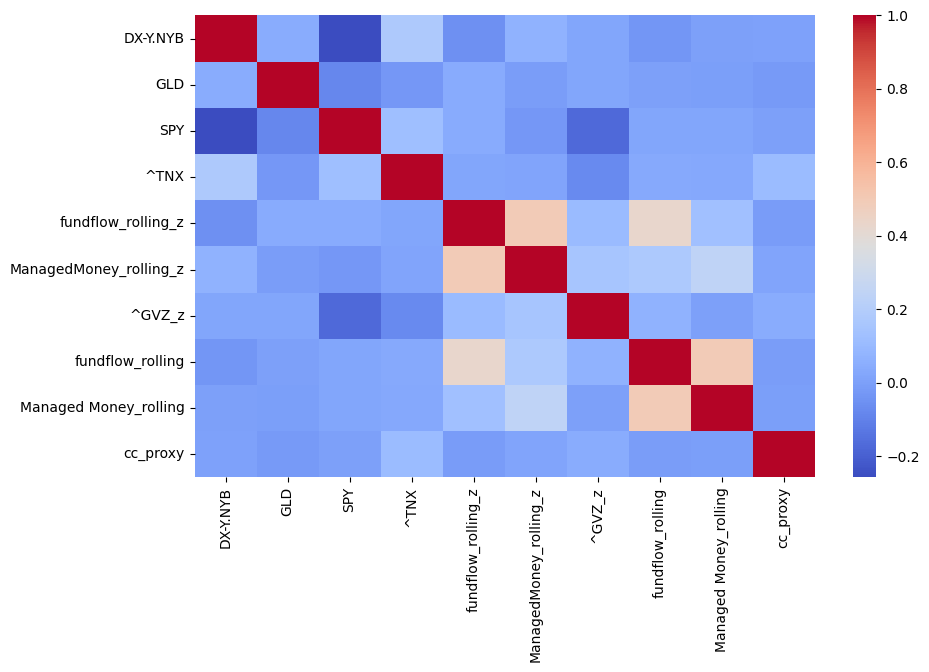

In [58]:
plt.figure(figsize=(10,6))
sns.heatmap(pred_df.corr(), cmap="coolwarm", annot=False)
plt.show()

Predictive Power is pretty low 

In [59]:
# Running predictive regression
Y = pred_df['GLD']
X = pred_df[filtered]

regr = sm.OLS(Y,sm.add_constant(X)).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7651
Date:                Mon, 01 Dec 2025   Prob (F-statistic):              0.649
Time:                        17:31:42   Log-Likelihood:                 1465.5
No. Observations:                 580   AIC:                            -2911.
Df Residuals:                     570   BIC:                            -2867.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0016      0.002      0.887      0.375      -0.002       0.005
DX-Y.NYB                   0.0696      0.089      0.782      0.435      -0.105       0.245
SPY                       -0.0603      0.037     -1.623      0.105      -0.133       0.013
^TNX                      -0.0078      0.014     -0.569      0.569      -0.035       0.019
fundflow_rolling_z         0.0010      0.001      1.423      0.155      -0.000       0.002
ManagedMoney_rolling_z    -0.0006      0.001     -1.034      0.302      -0.002       0.001
^GVZ_z                     0.0002      0.001      0.225      0.822      -0.001       0.002
fundflow_rolling       -5.534e-14   1.24e-13     -0.447      0.655   -2.98e-13    1.88e-13
Managed Money_rolling    1.25e-10   6.11e-10      0.204      0.838   -1.08e-09    1.33e-09
cc_proxy                  -0.3361      0.844     -0.398      0.691      -1.994       1.322
==============================================================================
Omnibus:                       15.085   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.457
Skew:                          -0.019   Prob(JB):                     2.43e-07
Kurtosis:                       4.122   Cond. No.                     8.85e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.85e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OOS using predicitve regression is even worse than in-sample

In [60]:
split = 0.7
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,shuffle=False)

# Fit OLS on train
model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

# Predict on test
Y_pred = model.predict(sm.add_constant(X_test))

# === True OOS R² Calc ===
SSE = ((Y_test - Y_pred)**2).sum()
SST = ((Y_test - Y_train.mean())**2).sum()

R2_OOS = 1 - SSE/SST
print("OOS R²:", R2_OOS)

OOS R²: -0.017369409944083536


Here, I conclude as below
- For contemporaneous regression, DXY, T10, cc_proxy seems to be contributing to explainability.
- Fundflows, Managed Money Position is not contributing for explaining gold price variability nor their coef is signficant.
- However, these factors didn't give any predicitve signals.
- I also learned that if Y, X are affected by the same shock then R^2 can be high but less economical interpretation

-> Putting gold miners etf in X or silver as an independent variable is one example
-> unless you want to calculate hedge ratio, such is not a good idea.